# Solutions for Lab Sheet 7 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-7-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd

## A random Signal - Task 1

We will deal with random signals in the following. A random signal with a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), a.k.a. Gaussian distribution, can be generated using `numpy`s function `np.random.normal()`. 

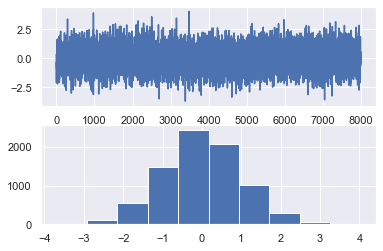

In [2]:
# create a normally distributed random signal of legth 1 second
noise=np.random.normal(size=8000)

# visualise the signal
plt.subplot(2,1,1)
plt.plot(noise)

# visualise the histogram
plt.subplot(2,1,2)
plt.hist(noise)

# listen to the sound file
ipd.Audio(noise, rate=8000)

## A periodically repeated Random Signal - Task 2

To add some *structure* to the signal we will generate a periodic random signal in the following by concatenating the same random signal several times.

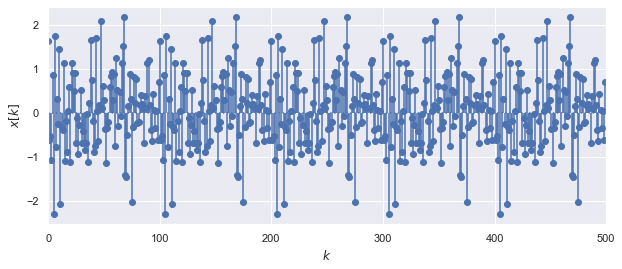

In [5]:
L = 8000 # total length of signal
P = 100  # period


K = 250  # upper/lower limit for lag in ACF


# generate periodic random signal
np.random.seed(1) # this ensures that always the same "random" signal is generated
x0 = np.random.normal(size=P)
x  = np.tile(x0, L//P)

plt.figure(figsize=(10, 4))
plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.grid(True)

# listen to the sound file
ipd.Audio(x, rate=8000)

## Autocorrelation Sequence, a.k.a. Autocorrelation Function

In the [previous notebook (Lab-Sheet 3)](./Lab-Sheet-3-Solution.ipynb) we calculated the [Correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and the correlation coefficient $\hat{r}_{xx}$ as a scalar quantity indicating how correated two signals (of the same length) are. Correlation in genetal is a statistical measure for the dependencies between random processes or between the samples of one random process.

In a more general it is also very interesting and useful to know whether a signal $x[k]$ correlates with a time-shifted version of itself $x[k-\kappa]$ or another signal $y[k]$ or $y[k-\kappa]$. As a result we are not only interested in the correlation between two signals $x[k]$ and $y[k]$ but also in the (auto-)correlation between $x[k]$ and $x[k-\kappa]$, the time-shifted version of $x[k]$ or the (cross-) correlation between $x[k]$ and $y[k-\kappa]$, respectively. This information can be analysed by the [auto-correlation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF) which characterizes the temporal dependencies within one random signal $x[k]$. It is an important measure for the analysis of signals in communications engineering, source coding and system identification. Today we will use it for estimation of the fundamantal frequency if a speech excitation signal.

### Background Theory and Definition

For a continuous-amplitude, real-valued random signal $x[k]$ the ACF is defined by the [second-order ensemble avarage](ensemble_averages.ipynb#Second-Order-Ensemble-Averages) of the signal at two different time-instants $k_1$ and $k_2$

\begin{equation}
r_{xx}[k_1, k_2] = \mathrm{E}\{ x[k_1] \cdot x[k_2] \}. \tag{1}
\label{eq:AutocorrelationDesinition}
\end{equation}

If we assume [wide-sense stationarity](stationary_ergodic.ipynb#Wide-Sense-Stationary-Random-Processes) (WSS) the ACF does only depend on the time difference $\kappa = k_1 - k_2$ between the considered sample indices

\begin{equation}
r_{xx}[\kappa] = \mathrm{E}\{x[k] \cdot x[k-\kappa] \}, \tag{2}
\label{eq:AutocorrelationDesinitionStationary}
\end{equation}

where $\kappa$ is commonly chosen as sample index instead of $k$ in order to indicate that it denotes a time shift / lag. The ACF quantifies the similarity of a signal with a shifted version of itself. It has high (positive / negative) values for high similarity and low (positive / negative) values for low similarity which is in line with our findings from [Lab-Sheet 3](./Lab-Sheet-3-Solution.ipynb).


### A Correlation Estimator

Since the definitions in (\ref{eq:AutocorrelationDesinition}) and (\ref{eq:AutocorrelationDesinitionStationary}) depend on the expectation operator $\mathrm{E}\{ \cdot \}$, which can only be estimated, rather than calculated, we are interested in such an estimator for $r_{xx}[\kappa]$. Thus, we define the *autocorrelation function estimate* at a time shift $\kappa$ of the signal $x[k]$ of length $L$ as

\begin{equation}
\hat{r}_{xx}[\kappa] = \frac{1}{L} \sum_{k=1}^{L}x[k]x[k+\kappa]  \tag{3}
\label{eq:AutocorrelationEstFullSum}
\end{equation}

for all values of $\kappa$ from $0$ to $L-1$, i.e., for each $\kappa$ we correlate the non-shifted signal with a signal shifted by $\kappa$ samples.

We observe that the sum in (\ref{eq:AutocorrelationEstFullSum}) is not well defined as  $x[k+\kappa]$ is unknown for $k+\kappa>L$. We have to assume that the signals are zero-padded by as many zeros before and after the actual data as needed to calculate the sum. We call this *zero-padding*.

\begin{equation}
\hat{r}_{xx}[\kappa] = \frac{1}{L} \sum_{k=1}^{L-\kappa}x[k]x[k+\kappa] \tag{4}
\label{eq:AutocorrelationEst}
\end{equation}



Note that in numerical implementations (e.g. MATLAB, Python with `mode='full'`), the computed ACF is stored in a vector of length $2 L - 1$. The positive indices $0, 1, \dots, 2 L - 2$ of this vector cannot be directly interpreted as $\kappa$. 
For an interpretation with respect to the actual time lag $\kappa$, $L-1$ must be subtracted from these indices.

Further note that $\frac{1}{L}$-averaging yields a [biased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of the ACF, which consistently should be denoted with $\hat{r}_{xx,\mathrm{biased}}[\kappa]$.
The unbiased estimator of the ACF is given as
$$\hat{r}_{xx,\mathrm{unbiased}}[\kappa] = \frac{1}{L-|\kappa|}\sum_{k=0}^{L-1} x_L[k] \cdot x_L[k-\kappa].$$




Therefore, we can stop the sum at index $L-\kappa$ since $y[k]$ becomes zero after that point.

The normalization must still be performed with the intended length $L$.
Hence, the right equality holds.

*Note:* Since we correlate the signal with (a shifted version of) itself it does not matter whether we shift a signal by $\kappa$ or by $-\kappa$.

If the second signal is shifted by $\kappa$ relative to the first, the first is shifted by $-\kappa$ relative to the second.

In other words, the autocorrelation is symmetric regarding $\kappa=0$.

(15999,)
Length of the signal x is L=8000
Length of the ACF is : 15999
[ 1.41730637e-04 -1.79265134e-04  1.01781303e-05 ...  1.01781303e-05
 -1.79265134e-04  1.41730637e-04]


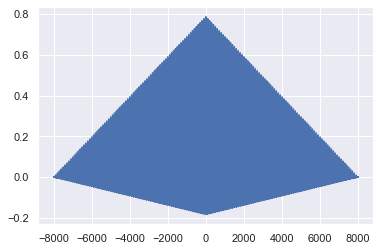

In [27]:
K = 250  # upper/lower limit for lag in ACF

# compute and truncate ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')

print(acf.shape)
print('Length of the signal x is L=' + str(len(x)))
print('Length of the ACF is : ' + str(len(acf)))
print(acf)

kappa = np.arange(-(L-1), L)
plt.figure()
plt.plot(kappa,acf)

Plotting as above makes no sense because there are too many points and we only see the bias triangle.

-249 <= kappa <= 249


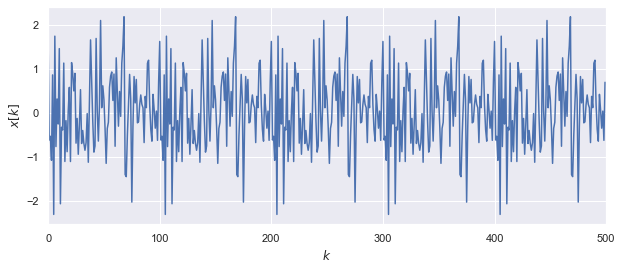

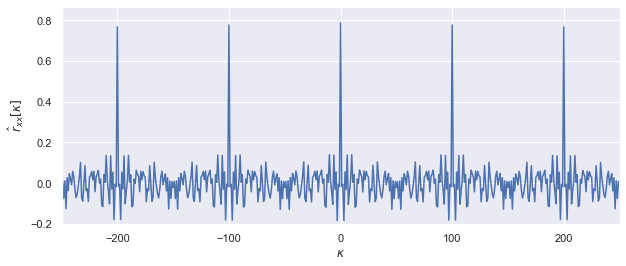

In [36]:
# compute and truncate ACF
acf = 1/len(x) * np.correlate(x, x, mode='full')
acf = acf[(len(x)-1)-(K-1):(len(x)-1)+K]
kappa = np.arange(-(K-1), K)
print(str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)) )

# plot signal and its ACF
plt.figure(figsize=(10, 4))
#plt.stem(x[:2*K], basefmt='C0:', use_line_collection=True)
plt.plot(x[:2*K])
plt.xlim(0, 2*K)
plt.xlabel('$k$')
plt.ylabel('$x[k]$')
plt.grid(True)

plt.figure(figsize=(10, 4))
#plt.stem(kappa, acf, basefmt='C0:', use_line_collection=True)
plt.plot(kappa, acf)
plt.xlabel('$\kappa$')
plt.ylabel('$\hat{r}_{xx}[\kappa]$ for ' + str(np.min(kappa)) + ' <= kappa <= ' + str(np.max(kappa)))
plt.axis([-K, K, 1.1*min(acf), 1.1*max(acf)])
plt.grid(True)

## Fundamental Frequency Estimation

With the knowledge from the [autocorrelation notebook](./autocorrelation.ipynb "Open Jupyter Notebook on Autocorrelation") we will now extract the fundamental frequency of a speech signal.
To do that we first calculate the autocorrelation estimate $\hat{r}_{xx}[k]$ of the signal and then look for the highest correlation value.
We only look in the time shifted range which corresponds to sensible frequencies (limited by $f_{min}$ and $f_{max}$):

For a given sample rate $f_s$ the period $n$ in samples relates to a given frequency $f$ by $n = \operatorname{round}\left(\frac{f_s}{f}\right).$
So for our maximal frequency $f_{max}$ we obtain the minimal time-shift $n_{min} = \operatorname{round}\left(\frac{f_s}{f_{max}}\right)$ and similarly the maximal time-shift $n_{max} = \operatorname{round}\left(\frac{f_s}{f_{min}}\right)$. Between those two values we find the time-shift $n_0$ of the maximal value which gives us the corresponding frequency $f_0 = \frac{f_s}{n_0}$.

The relation is also shown in the following figure where we see some autocorrelation sequence and observe how $f_{min}$ and $f_{max}$ constrain the search space for the highest autocorrelation value.

<img src="autocorrelation_frequencies.svg" align="center"/>
<center><span style="font-size:smaller">
    ACF frquencies
</span></center>

### Estimation of voiced/unvoiced speech

Lastly, for further processing, we want to know whether the correlation estimation was "good", "bad" or in between (where 0=good, 1=bad). If the correlation is below `correlation_min` or above `correlation_max` the correlation is deemed to be bad or good, respectively. For values in between we simply interpolate.
This value is called `noise_excitation_percentage` as the idea is that a high correlation value means that the signal consists mainly of impulses and hence the percentage of noise in the signal is low.
On the other hand, if the correlation is bad this means that lots of noise inhibited good correlation and hence the signal only contains little impulse (if at all). This then allows us to distinguish between voiced and unvoiced signals during the LPC analysis.

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 

## Overlap-Add

In [ ]:
def nextPowerOf2(L):
    '''
    Calculates the smallest power of 2 which is bigger than input variable n
    
    This helper function can be used to calculate an appropriate 
    length for an DFT which is longer than the signal length n and a power of 2.
    
    Input:
        L: int
            signal length
    Output:
        p: integer which is greater or equal than n and a power of 2
    
    Examples:
        for L in range(20):
            print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))
            
        x=ones(11)
        L_FFT=nextPowerOf2(len(x))
    '''
    if (L<2):
        return 2
    # If n is a power of 2 then return n 
    if (L and not(L & (L - 1))):
        return L
    # If n is NOT a power of 2 
    p = 1
    while (p < L) :
        p <<= 1 
    return p

In [ ]:
L_x = 32
L_h = 4
x=np.ones(L_x)
h=np.ones(L_h)

L_Bl  = 8   # block length (see Fig 2.25 in https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Ch2.S3.html)
L_hop = 8
L_DFT = nextPowerOf2(L_Bl+L_h-1)
# L_DFT = 16

noOfFrames = (L_x // L_hop) # number of blocks

# outer loop over mic channels
# h = np.zeros(L_DFT)
# h[:L_h] = h
H = np.fft.rfft(h, n=L_DFT)
oldBlock = []
for iFrame in range(noOfFrames):
    #x_block = np.zeros(L_DFT) # zero padding # not needed
    k = np.arange(iFrame*L_hop, iFrame*L_hop+L_Bl) # time vector
    x_block = x[k]
    # k = np.hstack((k,np.zeros(L_DFT-len(k))))  # zero padding
    X_block = np.fft.rfft(x_block, n=L_DFT)

    Y = X_block*H # frequency domain multiplication
    y = np.fft.irfft(Y, n=L_DFT)

    k2 = np.arange(iFrame*L_hop, iFrame*L_hop+L_DFT) # time vector
    plt.figure()
    plt.stem(k2,y)